In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Functions

In [3]:
def Dev (y_true, y_pred):
    from sklearn.metrics import r2_score
    import numpy as np
    return 100*np.sum(np.abs(y_pred - y_true))/np.sum(np.abs(y_true)),r2_score(y_pred,y_true)


def WAPE (y_true, y_pred):
    import numpy as np
    return  100*np.sum(np.abs(y_pred - y_true))/np.sum(np.abs(y_true))

def plot_y_feat (WAPE_features , plt_name = 'Name [-]' ):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.path as mpath
    import numpy as np
    
    plt.figure(1,figsize=(13,5))
    plt.style.use('seaborn-whitegrid')
    plt.axis ('auto')
    plt.plot(np.arange(len(WAPE_features.index)), np.array(WAPE_features), color = 'blue',  markersize = 5, linestyle = '-')
    plt.xticks(np.arange(len(WAPE_features.index)),WAPE_features.index, rotation=40, fontsize=8,horizontalalignment="right", wrap=True)
    plt.ylabel('WAPE [%]', wrap=True)
    fig = plt.figure(1)
    fig.canvas.set_window_title(plt_name)
    
    

def feature_sel_1 (estimator,Features,Target,Save_address,cv=10):
  import pandas as pd
  from sklearn.model_selection import cross_val_predict
  import matplotlib as mpl
  import matplotlib.pyplot as plt
  import os
  # Find the correlation matrix, and find the abs(correlation) of each feature with the target
  correlation = abs((pd.concat((Features,Target), axis = 1).corr())[Target.columns[0]]).sort_values(ascending=False).dropna().drop(Target.columns[0])
  correlation_list  = list(correlation.index) 

  # Order the features based on the corresponding correlation
  DF_Features=pd.DataFrame(index = Features.index)
  FeatureSelection = pd.Series(index = correlation_list) 
  for feat in correlation_list:
    DF_Features= pd.concat((DF_Features, Features[feat]), axis=1)
    FeatureSelection[feat]=WAPE(Target.iloc[:,0],pd.DataFrame(index=Target.index,data=cross_val_predict(estimator,DF_Features,Target, cv = cv, n_jobs = -1)).iloc[:,0])


  #choose the set of features which leads to minimum WAPE
  FeatureSelection_selected = FeatureSelection[:(str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",''))]   

  #among the remaining features, the ones that increase the overall obtained error are discarded
  FeatureSelection_neg = FeatureSelection 

  for feat in  correlation_list[1:]:
      if ((FeatureSelection.shift(+1)).loc[feat]) >= (FeatureSelection.loc[feat]): 
          continue
      else:
          FeatureSelection_neg = FeatureSelection_neg.drop([feat])

  FeatureSelection_neg_after = FeatureSelection_neg[(str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",'')):].drop((str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",'')))
  
  #the remaining ones are sorted in a descending order based on the overall error obtained while adding them.
  FeatureSelection_selected = pd.concat((FeatureSelection_neg_after.sort_values(ascending=False),FeatureSelection_selected.sort_values(ascending=False)), axis = 0)
  
  #Plot and save the figure
  plt_name ='selected_features_step1'+'.png'
  plot_y_feat(FeatureSelection , plt_name = plt_name)
  plt.savefig(os.path.join(Save_address,plt_name), dpi = (400))

  return FeatureSelection_selected

def feature_sel_2(estimator,Features,Target,FeatureSelection,Save_address,cv=10):
  import matplotlib as mpl
  import matplotlib.pyplot as plt
  import os

  #Selection of the features according to their WAPE
  import pandas as pd
  from sklearn.model_selection import cross_val_predict
  DF_features_selected = Features[FeatureSelection.index]
  #reverse the order of columns
  DF_features_selected=DF_features_selected.iloc[:, ::-1]


  #same as previous step features are added gradually and the obtained WAPE is monitored
  FeatureSelection = pd.Series(index = DF_features_selected.columns) 
  DF_Features=pd.DataFrame(index = Features.index)
  for feat in DF_features_selected.columns:
    DF_Features= pd.concat((DF_Features, DF_features_selected[feat]), axis=1)
    FeatureSelection[feat]=WAPE(Target.iloc[:,0],pd.DataFrame(index=Target.index,data=cross_val_predict(estimator,DF_Features,Target, cv = cv, n_jobs = -1)).iloc[:,0])
  
  #Selecting the set of features which leads to minmum WAPE
  FeatureSelection_selected_updated = FeatureSelection[:(str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",''))]          
  
  
  #Plot and save the figure
  plt_name ='selected_features_step2'+'.png'
  plot_y_feat(FeatureSelection , plt_name = plt_name)
  plt.savefig(os.path.join(Save_address,plt_name), dpi = (400))

  return FeatureSelection_selected_updated



def feature_sel_3(algorithm,Features,Target,FeatureSelection,Save_address,cv=10):
  import matplotlib as mpl
  import matplotlib.pyplot as plt
  import os
  import pandas as pd
  from sklearn.model_selection import cross_val_predict
  DataSet_features=Features[FeatureSelection.index]

  DF_features=DataSet_features.copy()
  features=pd.DataFrame(index=DataSet_features.index)
  Final_WAPE_results=pd.Series()

  for i in range(len(DataSet_features.columns)) :
    WAPE_values_this_iter=pd.Series()
    for feat in DF_features.columns :
      features=pd.concat((features,DataSet_features[feat]),axis=1)
      WAPE_values_this_iter[feat]=WAPE(Target.iloc[:,0],pd.DataFrame(index=Target.index,data=cross_val_predict(algorithm,features,Target, cv = cv, n_jobs = -1)).iloc[:,0])
      features=features.drop(feat,axis=1)
      
    features=pd.concat((features,DataSet_features[WAPE_values_this_iter.idxmin()]),axis=1)
    DF_features=DF_features.drop(WAPE_values_this_iter.idxmin(),axis=1)
    Final_WAPE_results[WAPE_values_this_iter.idxmin()]=WAPE_values_this_iter.min()
    


  FeatureSelection_final = Final_WAPE_results[:(str(Final_WAPE_results[(Final_WAPE_results == Final_WAPE_results.min())].index.values.tolist()).replace("['",'').replace("']",''))]          
  DF_features_selected_Final = DataSet_features[FeatureSelection_final.index]
 
  #Plot and save the figure
  plt_name ='selected_features_step3'+'.png'
  plot_y_feat(Final_WAPE_results)
  plt.savefig(os.path.join(Save_address,plt_name), dpi = (400))

  return DF_features_selected_Final

##Import needed modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

##Importing the data we generated last week

In [8]:
path_processed_data = "/content/gdrive/MyDrive/EETBS /Data/ML_Data.csv"
DF_mod = pd.read_csv(path_processed_data,index_col=0,parse_dates=[0])
DF_mod = DF_mod["2014-08-01":"2014-08-30"] #As the process takes time, we narrow the scope to month of August only.
DF_mod.head(3)

,consumption,temperature,Irradiance,temperature -1h,temperature -2h,temperature -3h,temperature -4h,temperature -5h,temperature -6h,consumption -1h,consumption -2h,consumption -3h,consumption -4h,consumption -5h,consumption -6h,consumption -7h,consumption -8h,consumption -9h,consumption -10h,consumption -11h,consumption -12h,consumption -13h,consumption -14h,consumption -15h,consumption -16h,consumption -17h,consumption -18h,consumption -19h,consumption -20h,consumption -21h,consumption -22h,consumption -23h,consumption -24h,Irradiance -3h,Irradiance -4h,Irradiance -5h,Irradiance -6h,hour,sin_hour,cos_hour,dayOfWeek,weekendFlag,month,WeekOfYear,workingHour
2014-08-01 00:00:00,825.183333,76.74,0.0,79.05,80.37,83.20,85.73,88.08,90.71,1665.416667,2237.616667,2392.883333,2463.150000,1901.133333,2372.483333,2638.733333,1349.116667,636.483333,545.616667,157.616667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,345.25,264.75,503.80,813.683333,1174.200000,0.0,0.011767,0.644467,1.429150,0,0.000000,1.000000,4,0.0,8,31,0
2014-08-01 01:00:00,677.516667,76.22,0.0,76.74,79.05,80.37,83.20,85.73,88.08,825.183333,1665.416667,2237.616667,2392.883333,2463.150000,1901.133333,2372.483333,2638.733333,1349.116667,636.483333,545.616667,157.616667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,345.25,264.75,503.800000,813.683333,0.0,0.000000,0.011767,0.644467,1,0.258819,0.965926,4,0.0,8,31,0
2014-08-01 02:00:00,535.883333,75.20,0.0,76.22,76.74,79.05,80.37,83.20,85.73,677.516667,825.183333,1665.416667,2237.616667,2392.883333,2463.150000,1901.133333,2372.483333,2638.733333,1349.116667,636.483333,545.616667,157.616667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,345.25,264.750000,503.800000,0.0,0.000000,0.000000,0.011767,2,0.500000,0.866025,4,0.0,8,31,0


In [9]:
DF_target = DF_mod["consumption"]
DF_features = DF_mod.drop("consumption",axis=1) #Remove a column called consumption and keep the rest of the dataframe

##Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor
reg_RF = RandomForestRegressor(random_state=6)

from sklearn.model_selection import cross_val_predict
predict_RF_cv = cross_val_predict(reg_RF,DF_features,DF_target,cv = 5)

In [11]:
print("WPR: %5.3f \n R2: %5.3f " % Dev(DF_target,predict_RF_cv)) #%5.3f: 5 number with 3 fractional digits

WPR: 21.251 
 R2: 0.860 


##Plotting real vs. predicted data

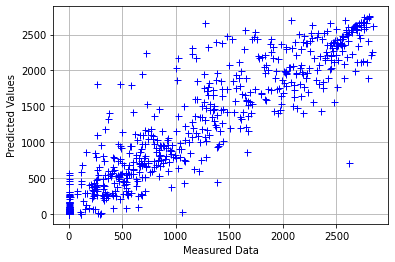

In [12]:
plt.plot(DF_target,predict_RF_cv,"+",color="b",markersize=7)
plt.xlabel("Measured Data")
plt.ylabel("Predicted Values")
plt.grid()

Wherever x=y, the predicted values are accurate.

##Plotting vs. time (real and predicted)

<Figure size 720x360 with 0 Axes>

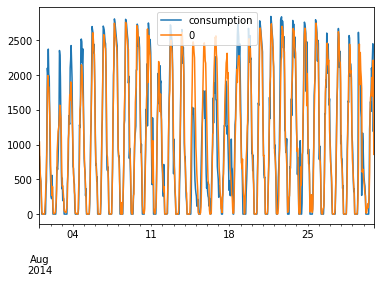

In [14]:
plt.figure(figsize=(10,5))
DF_target_DF = pd.DataFrame(DF_target)
DF_predict_RF_cv = pd.DataFrame(predict_RF_cv,index=DF_target_DF.index)
joined_DF_toPlot = DF_target_DF.join(DF_predict_RF_cv)
joined_DF_toPlot.plot()

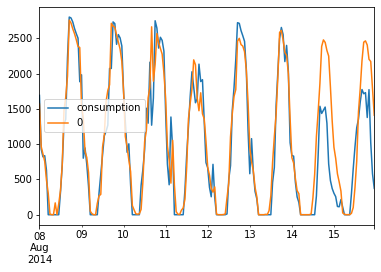

In [15]:
joined_DF_toPlot_aWeek = joined_DF_toPlot.loc["2014-08-08":"2014-08-15"]
joined_DF_toPlot_aWeek.plot()

##Step 2: Feature selection

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


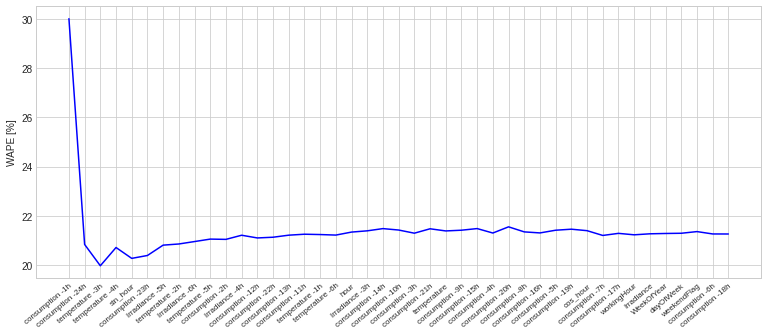

In [16]:
path_to_save = "/content/gdrive/MyDrive/EETBS /Data/"
cv = 5
featureSelection_1 = feature_sel_1(reg_RF,DF_features,pd.DataFrame(DF_target),path_to_save,cv)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


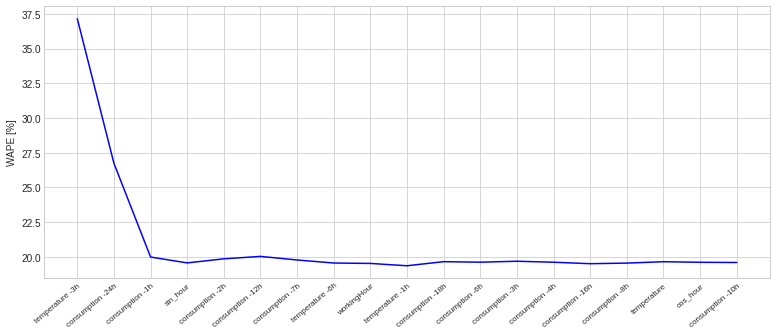

In [17]:
featureSelection_2 = feature_sel_2(reg_RF,DF_features,pd.DataFrame(DF_target),featureSelection_1,path_to_save,cv)

In [20]:
featureSelection_2

temperature -3h     37.157097
consumption -24h    26.736293
consumption -1h     19.983339
sin_hour            19.561045
consumption -2h     19.855308
consumption -12h    20.029355
consumption -7h     19.771372
temperature -6h     19.551935
workingHour         19.522855
temperature -1h     19.354545
dtype: float64

In [24]:
featureSelection_2_mod = featureSelection_2[0:4]

In [25]:
featureSelection_2_mod

temperature -3h     37.157097
consumption -24h    26.736293
consumption -1h     19.983339
sin_hour            19.561045
dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


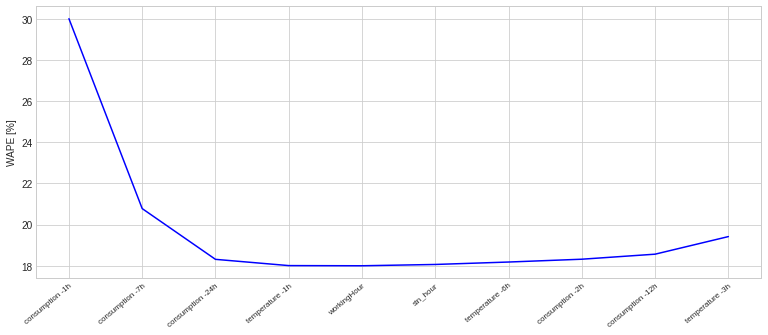

In [18]:
Selected_Features = feature_sel_3(reg_RF,DF_features,pd.DataFrame(DF_target),featureSelection_2,path_to_save,cv)

In [19]:
Selected_Features

,consumption -1h,consumption -7h,consumption -24h,temperature -1h,workingHour
2014-08-01 00:00:00,1665.416667,2638.733333,1174.200000,79.05,0
2014-08-01 01:00:00,825.183333,2372.483333,813.683333,76.74,0
2014-08-01 02:00:00,677.516667,1901.133333,503.800000,76.22,0
2014-08-01 03:00:00,535.883333,2463.150000,264.750000,75.20,0
2014-08-01 04:00:00,474.450000,2392.883333,345.250000,75.20,0
...,...,...,...,...,...
2014-08-30 19:00:00,2028.566667,238.166667,1385.933333,90.48,0
2014-08-30 20:00:00,2234.750000,1219.783333,269.050000,88.51,0
2014-08-30 21:00:00,2448.183333,1422.983333,775.466667,86.60,0
2014-08-30 22:00:00,1186.650000,1616.533333,1166.250000,84.36,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


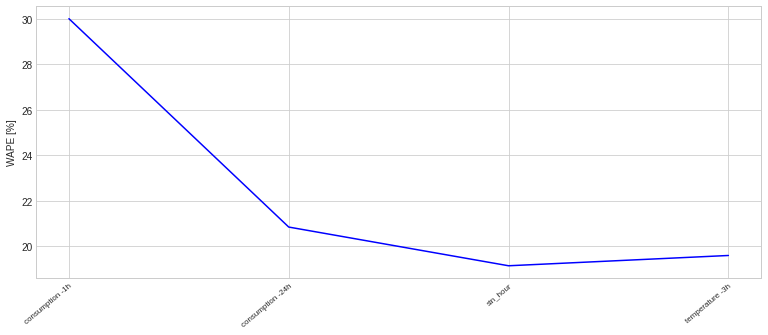

In [26]:
Selected_Features_mod = feature_sel_3(reg_RF,DF_features,pd.DataFrame(DF_target),featureSelection_2_mod,path_to_save,cv)

##Step 3: Algorithm (pipeline) optimization-Tpot

Pay attehntion that there are currently several modules that do this automation of optimizing the algorithm optimization.

This list can include auto sklearn, H20 Auto ML, google auto ML module.

In [ ]:
!pip install tpot

In [ ]:
# Number of folds cross validation & gen 
cv=5
pop=30
#gen=100
gen=100


In [ ]:
import numpy as np
from sklearn.metrics.scorer import make_scorer   
from sklearn.model_selection import cross_val_predict
from tpot import TPOTRegressor


WAPE_scorer_error = make_scorer(WAPE, greater_is_better = False) 

pipeline_optimizer = TPOTRegressor(generations = gen, population_size = pop,verbosity=2,scoring =  AMARD_scorer_error, use_dask = False, max_eval_time_mins = 1)
pipeline_optimizer.fit(Selected_Features, DF_target)



Generation 1 - Current best internal CV score: -18.272495818390105

Generation 2 - Current best internal CV score: -18.272495818390105

Generation 3 - Current best internal CV score: -18.202084573047387

Generation 4 - Current best internal CV score: -18.186366663936358

Generation 5 - Current best internal CV score: -17.75144234747541

Generation 6 - Current best internal CV score: -17.608693382077234

Generation 7 - Current best internal CV score: -17.580901927483897

Generation 8 - Current best internal CV score: -17.34725058302724

Generation 9 - Current best internal CV score: -17.34725058302724

Generation 10 - Current best internal CV score: -17.34725058302724

Generation 11 - Current best internal CV score: -17.34725058302724

Generation 12 - Current best internal CV score: -17.23331703278745

Generation 13 - Current best internal CV score: -17.23331703278745

Generation 14 - Current best internal CV score: -17.23331703278745

Generation 15 - Current best internal CV score: -1

TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=25,
              log_file=None, max_eval_time_mins=1, max_time_mins=None,
              memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=30,
              random_state=None,
              scoring=make_scorer(AMARD, greater_is_better=False),
              subsample=1.0, template=None, use_dask=False, verbosity=2,
              warm_start=False)

In [ ]:
OptimalPipeline_name='tpot_exported.py'
OptimalPipeline_path=os.path.join(path_to_save,OptimalPipeline_name)
print(OptimalPipeline_path)

pipeline_optimizer.export(OptimalPipeline_path)

/content/tpot_exported.py


In [ ]:
def Pipeline_extractor(FileName):
  """This is a simple function that reads the pipeline that is exported from tpot and only runs the needed 
  import lines and along with the exported pipeline and evades everything else
  """ 
  s = open(FileName).read()
  EndOfImportedFunctions=s.find("# NOTE: Make sure that")
  Text_modules_to_import=s[0:EndOfImportedFunctions]
  StartofExportedPipeline = s.find("exported_pipeline")
  EndofExportedPipeline=s.find("\nexported_pipeline.fit")
  Text_exported_pipeline = s[StartofExportedPipeline:EndofExportedPipeline]
   
  return Text_modules_to_import,Text_exported_pipeline

In [ ]:
Text_modules_to_import,Text_exported_pipeline=Pipeline_extractor(OptimalPipeline_path)
exec(Text_modules_to_import)   
exec(Text_exported_pipeline)

In [ ]:
predict_Tpot_CV_Selected= cross_val_predict(exported_pipeline,Selected_Features, DF_target, cv=5)
print("WAPE: %5.2f \n R2: %5.2f " % Dev(DF_target,predict_Tpot_CV_Selected))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

AMARD: 17.03 
 R2:  0.91 


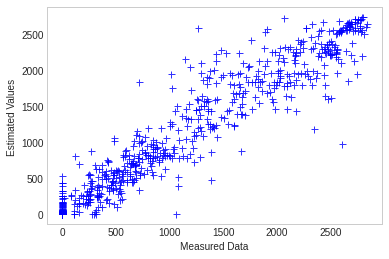

In [ ]:
plt.plot(DF_target, predict_Tpot_CV_Selected, '+', color = 'b', markersize = 7,  markeredgewidth = 1, alpha = 0.8) 
plt.xlabel('Measured Data', wrap=True)
plt.ylabel('Estimated Values ', wrap=True)
plt.grid()




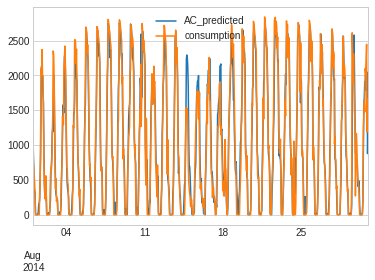

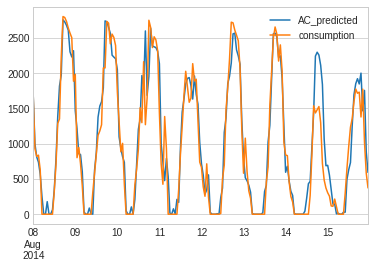

In [ ]:
Aug(predict_Tpot_CV_Selected)